## Anomaly Detection- windowed method 

In [1]:
import numpy as np
import pandas as pd
import keras
from keras import layers
from matplotlib import pyplot as plt
import tensorflow as tf
from keras.layers import Lambda, Input, Dense, Dropout

Importing the dataset

In [2]:
data = pd.read_csv("data/realKnownCause/realKnownCause/machine_temperature_system_failure.csv",
                   parse_dates=True, index_col="timestamp")

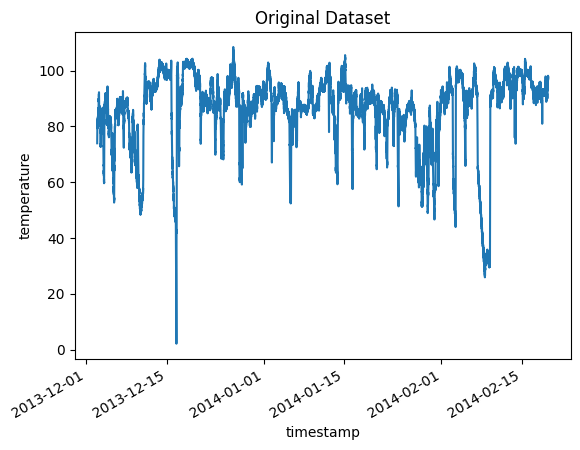

In [3]:
fig, ax = plt.subplots()
data.plot(legend=False, ax=ax)
plt.ylabel("temperature")
plt.title("Original Dataset")
plt.show()

Splitting training and testing

In [4]:
# Splitting to train and test
test_ratio =0.3
start = int(len(data) * 0.25 )  # or 0 
tr_data = data.iloc[start: int(len(data) * (1 - test_ratio))]
tst_data1 = data.iloc[int(len(data) * (1 - test_ratio)) :]
tst_data2 = data.iloc[0:start]

In [5]:
tr_data

,value
timestamp,
2013-12-22 14:00:00,87.168898
2013-12-22 14:05:00,87.933798
2013-12-22 14:10:00,85.804768
2013-12-22 14:15:00,85.955663
2013-12-22 14:20:00,86.815269
...,...
2014-01-26 23:40:00,88.470506
2014-01-26 23:45:00,88.395883
2014-01-26 23:50:00,88.608302


Normailzing the training set 

In [6]:
# Normalize and save the mean and std we get, for normalizing test data.
training_mean = tr_data.mean()
training_std = tr_data.std()
train_scaled = (tr_data - training_mean) / training_std
print("Number of training samples:", len(train_scaled))

Number of training samples: 10213


Function to create the windowed data

In [7]:
# Generated training sequences for use in the model.
def create_sequences(values, time_steps):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

In [8]:
step_size = 288

train = create_sequences(train_scaled.values, step_size)
print("Training input shape: ", train.shape)

Training input shape:  (9926, 288, 1)


VAE model

In [9]:
from utils.sample import sample
from model.VAELossLayer import VAELossLayer

In [10]:
# Encoder
latent_dim = 8  # Dimensionality of the latent space
encoder_inputs = Input(shape=(train.shape[1], train.shape[2]))
x = layers.Conv1D(
    filters=32,
    kernel_size=7,
    padding="same",
    strides=2,
    activation="relu",
)(encoder_inputs)
x = layers.Dropout(rate=0.2)(x)
x = layers.Conv1D(
    filters=16,
    kernel_size=7,
    padding="same",
    strides=2,
    activation="relu",
)(x)
x = layers.Flatten()(x)
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)

# Use Lambda layer to sample from the latent distribution
z = layers.Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Instantiate encoder model
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder
latent_inputs = Input(shape=(latent_dim,))
x = Dense(train.shape[1]*16, activation='relu')(latent_inputs)
x = layers.Reshape((int(train.shape[1]/4), 64))(x)  # Adjusted reshape operation
x = layers.Conv1DTranspose(
    filters=32,
    kernel_size=7,
    padding="same",
    strides=2,
    activation="relu",
)(x)
x = layers.Dropout(rate=0.2)(x)
x = layers.Conv1DTranspose(
    filters=16,
    kernel_size=7,
    padding="same",
    strides=2,
    activation="relu",
)(x)
decoder_outputs = layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same")(x)


# Instantiate decoder model
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

# Instantiate VAE model
outputs = decoder(encoder(encoder_inputs)[2])



vae_loss_layer = VAELossLayer()([encoder_inputs, outputs, z_mean, z_log_var])

#vae = keras.Model(encoder_inputs, outputs, name="vae")
vae = keras.Model(encoder_inputs, [outputs, vae_loss_layer], name='vae')

vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))

In [11]:
vae.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 288, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 144, 32)   │        256 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 144, 32)   │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 72, 16)    │      3,600 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ [(None, 8),       │     22,304 │ input_layer[0][0] │
│ (Functional)        │ (None, 8), (None, │            │                   │
│                     │ 8)]               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1152)      │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 288, 1)    │     59,553 │ encoder[0][2]     │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 8)         │      9,224 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 8)         │      9,224 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_loss_layer      │ (None, 288, 1)    │          0 │ input_layer[0][0… │
│ (VAELossLayer)      │                   │            │ decoder[0][0],    │
│                     │                   │            │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 81,857 (319.75 KB)

 Trainable params: 81,857 (319.75 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = vae.fit(
    train,
    train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)])

Epoch 1/50


70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 25849.1758 - val_loss: 6743.6855
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4914.5771 - val_loss: 2965.1599
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2824.9404 - val_loss: 2342.7444
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2309.8906 - val_loss: 2296.7900
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2114.3276 - val_loss: 2280.4487
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1928.6790 - val_loss: 2353.4043
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1846.0145 - val_loss: 2343.8018
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1723.2037 - val_loss: 2330.7866
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1620.3143 - val_loss: 2394.6060
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1627.6918 - val_loss: 2384.5896
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1507.8729 - val_loss: 2498.1667
Epoch 1

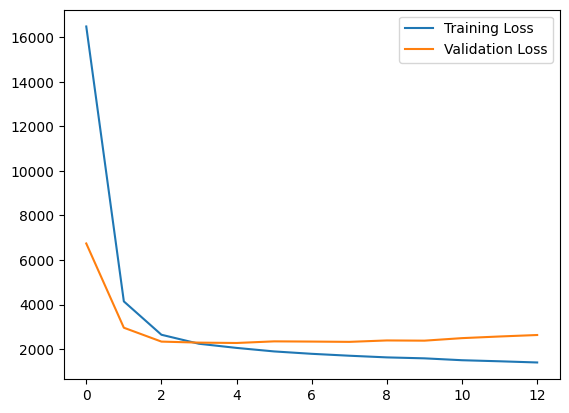

In [13]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

311/311 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
(9926, 1)


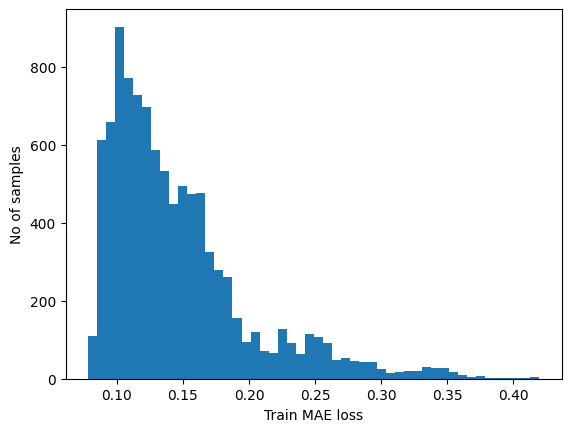

Reconstruction error threshold:  0.41975524938765896


In [14]:
# Get train MAE loss.
train_pred = vae.predict(train)[0]
train_mae_loss = np.mean(np.abs(train_pred - train), axis=1)
print(train_mae_loss.shape)
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

In [15]:
print(train_pred.shape)

(9926, 288, 1)


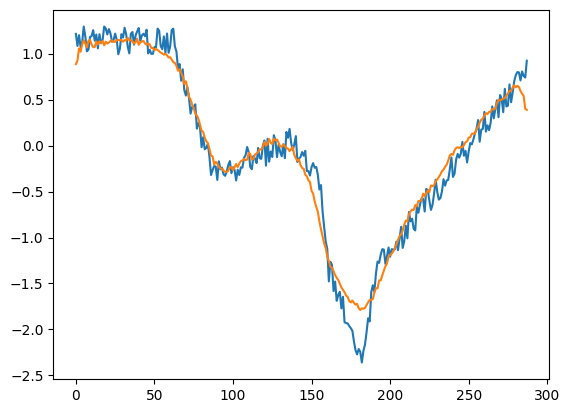

In [16]:
# Checking how the first sequence is learnt
plt.plot(train[90])
plt.plot(train_pred[90])
plt.show()

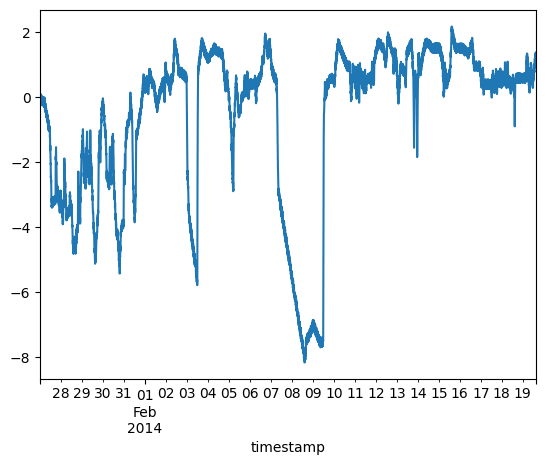

Test input shape:  (6522, 288, 1)
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
(6522, 1)


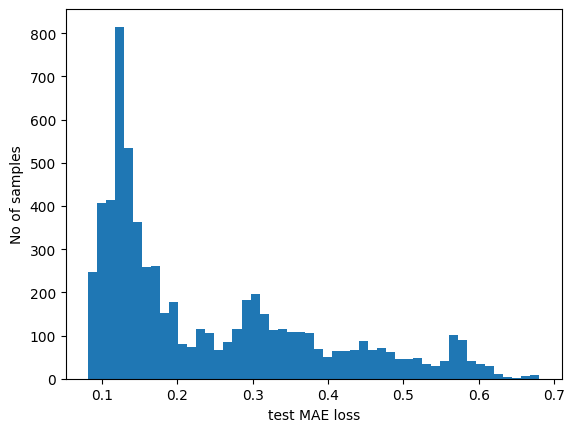

Number of anomaly samples:  972
Indices of anomaly samples:  (array([ 124,  125,  126,  127,  128,  129,  130,  131,  132,  146,  147,
        148,  149,  150,  151,  152,  153,  154,  155,  156,  157,  158,
        159,  160,  161,  162,  163,  164,  165,  166,  167,  168,  169,
        170,  171,  172,  173,  174,  212,  213,  214,  267,  268,  269,
        270,  271,  272,  273,  274,  275,  276,  277,  278,  279,  280,
        281,  314,  315,  316,  317,  318,  319,  320,  321,  322,  323,
        324,  325,  326,  327,  328,  329,  330,  331,  333,  334,  335,
        336,  394,  395,  396,  397,  398,  399,  400,  425,  426,  427,
        428,  429,  430,  431,  432,  433,  434,  435,  436,  437,  438,
        439,  440,  441,  442,  443,  444,  445,  446,  447,  448,  449,
        450,  451,  452,  453,  454,  455,  456,  457,  458,  459,  460,
        461,  462,  463,  464,  465,  466,  467,  468,  493,  494,  495,
        496,  497,  498,  499,  500,  501,  502,  503,  504,  

In [17]:

tst_data= tst_data1          #1 or 2
test_scaled = (tst_data - training_mean) / training_std
fig, ax = plt.subplots()
test_scaled.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
test = create_sequences(test_scaled.values, step_size)
print("Test input shape: ", test.shape)

# Get test MAE loss.
test_pred = vae.predict(test)[0]
test_mae_loss = np.mean(np.abs(test_pred - test), axis=1)
print(test_mae_loss.shape)
#test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [18]:
# anomalous_data_indices = []
# for ind in range(len(anomalies)):
#     if anomalies[ind]:
#         anomalous_data_indices.append(ind)

In [19]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
step_size = 288
anomalous_data_indices = []
for data_idx in range(step_size - 1, len(test_scaled) - step_size + 1):
    if np.all(anomalies[data_idx - step_size + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

In [20]:
print("Indices of anomalies: ", anomalous_data_indices)

Indices of anomalies:  [3520, 3521, 3522, 3523, 3524, 3525, 3526, 3527, 3528, 3529, 3530, 3531, 3532, 3533, 3534, 3535, 3536, 3537, 3538, 3539, 3540, 3541, 3542, 3543, 3544, 3545, 3546, 3547, 3548, 3549, 3550, 3551, 3552, 3553, 3554, 3555, 3556, 3557, 3558, 3559, 3560, 3561, 3562, 3563, 3564, 3565, 3566, 3567, 3568, 3569, 3570, 3571, 3572, 3573, 3574, 3575, 3576, 3577, 3578, 3579, 3580, 3581, 3582, 3583, 3584, 3585, 3586, 3587, 3588, 3589, 3590, 3591, 3592, 3593, 3594, 3595, 3596, 3597, 3598, 3599, 3600, 3601, 3602, 3603, 3604, 3605, 3606, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3632, 3633, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3648, 3649, 3650, 3651, 3652, 3653, 3654, 3655, 3656, 3657, 3658, 3659, 3660, 3661, 3662, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670, 3671, 3672, 3673, 3674, 3675, 3676, 3677, 3678, 3679, 3680, 3681, 3682

In [21]:
data['label'] = 1
instances= [["2013-12-10 06:25:00","2013-12-12 05:35:00"],
            ["2013-12-15 17:50:00","2013-12-17 17:00:00"],
            ["2014-01-27 14:20:00","2014-01-29 13:30:00"],
            ["2014-02-07 14:55:00","2014-02-09 14:05:00"]]


In [22]:
df_subset = tst_data.iloc[anomalous_data_indices]
df_subset

,value
timestamp,
2014-02-08 05:25:00,39.112686
2014-02-08 05:30:00,38.479101
2014-02-08 05:35:00,38.019513
2014-02-08 05:40:00,37.714026
2014-02-08 05:45:00,38.502890
...,...
2014-02-09 01:30:00,33.538369
2014-02-09 01:35:00,33.880475
2014-02-09 01:40:00,35.178794


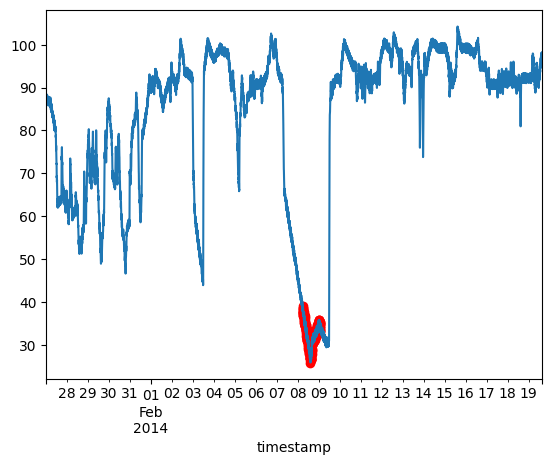

In [23]:
fig, ax = plt.subplots()
tst_data.plot(legend=False, ax=ax)
ax.scatter(df_subset.index, df_subset['value'], color="r")
plt.show()